# Identification of gait events using LSTM networks

In [1]:
%matplotlib inline
%pylab inline
from utils import *

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Problem statement

We analyze over $2000$ gait lab visits, each consisting of several trials, $10622$ trials in total. In each patient was asked to walk normally for approx. $10$ meters and his movement was registered using motion caputre technology at $120$Hz. Marker trajectories from the motion capture recorders were then translated to kinematics curves. We observed time series of $5$ joints: hip, pelvis, knee, ankle, foot $3$ DOF each, sampled at $120$Hz, as well as toes, ankle, knee and ASI markers' positions.

For each trial per leg $r$ we have $n_r$ sampling points of $5$ joints and $4$ markers, $3$ DOF. Input observations are stored as matrices $X_r \in \mathbb{R}^{n_r \times 27}$. For each trial we have some of the events (foot strike / toes off) annotated. Let's focus on the foot strike event. We encode these events as a binary vector $Y_r \in \{ 0, 1\}^{n_r}$. The task is to predict these events. Formally we are looking for a function $f$ such that $\hat{Y}_{r} = f(X_{r})$, such that $\hat{Y}_{r,t} \sim Y_{r,t}$ for $t \in \{1,...,T_r\}$.

Since occurance of events is sparse, i.e. there are not many $1$ compared to $0$ in $Y_r$, we use a weighted binary crossentropy, penalazing misclassified $1$'s with $100:1$ proportion,

\begin{align*}
  H(Y_r,\hat{Y_r}) &= - \sum_{1 \leq t \leq T_r} 100 \cdot Y_{r,t} \log \hat{Y}_{r,t}\\
  &+ (1-Y_{r,t}) \log (1-\hat{Y}_{r,t}).
\end{align*}

Now, if we find $f$ minimizing $H(Y_r,f(X_{r}))$, real valued process $f(X_{r})$ can be interpreted as likelihood of event. Peaks of certain magnitude in this process will correspond to predicted events.

For training the network we will use fixed length sequences. We set the length to `nseqlen` and use only samples from the first event `nstart - nrand` where `nstart` is the first nonzero element in $Y_r$ and `nrand` is a random integer between `nseqlen / 2`. We do this subtraction in order to simulate starting from different points - to make the procedure robust to various setups.

In [2]:
# Settings
input_dim = 99 #27*2
output_dim = 1
nseqlen = 128
fdir = "/media/lukasz/TOSHIBA EXT/csv-hee"

# Load data
inputs, outputs, ids = load_data(fdir, input_dim, output_dim, nseqlen, nsamples = 40000)
n = inputs.shape[0]
ntrain = int(math.floor(n * 0.9))

Now `inputs` contains $10000$ matrices $X \in \mathbb{R}^{\verb|nseqlen| \times 27}$ and `outputs` are corresponding output vectors $Y_r \in \{ 0, 1\}^{\verb|nseqlen|}$.

### Interpretable error

We use crossentropy as a differentiable function which helps to identify the regions of intrest. Yet, the practical usefulness of the method can be determined by average number of frames between predicted annotations and true annotations. Let $E_r$ is the set of events and $\hat{E}_r$ the predicted set of events. Let $S$ be a set of traials from the test set on which numbers of predicted and true annotations are equal.

* $\verb|coverage| = |S|$,
* $\verb|distance| = $ average distance between true and predicted annotations on $S$, where by distance we mean minimal average absolute distance between pairs of values from $E_r$ and $\hat{E}_r$.

Both of these measures are not smooth so we can't use them directly in the training. However, if we optimize cross-entropy to $0$ then also these two measures are optimized. 

## Network

Our algorithm can be summarized as follows. First, we construct a neural network for approximating likelihood of event. Next, we train the network on short sequences and we test it on the test set. We check loss function on the test set to rull out overfitting and next we apply peak detection algorithm for identifying the actual events. We manually verify if predictions are of sufficient quality.

### Architecture

We propose following architecture of the network:
* $15$ dimensional kinematics time series as input,
* $d$ LSTM layers mapping the input to a $p$ dimensional time series,
* LSTM layer mapping the previous layer to $2$ dimensional time series,

where $d \in \{0,1,2\}$ and $p \in \{16,32,64\}$.

### Training

We use $10000$ kinematics matrices $X \in \mathbb{R}^{\verb|nseqlen| \times 15}$ and corresponding output vectors $Y_r \in \{ 0, 1\}^{\verb|nseqlen|}$. We split the dataset into:
* training set (for training the model)
* validation set (for checking the accuracy of the training given the parameters)
* test set (for final evaluation of the model)

We split it in $81-9-10$ proportion.

After preliminary analysis of the training and test set errors, we choose to run $500$ epochs. Preliminary experiments showed that the batch size has little influence on the accuracy and we decide to set $32$, since the training seems stable with this value.

In [11]:
# Build the model
def construct_model(hidden = 32, lstm_layers = 2, input_dim = 15, output_dim = 2):
    model = Sequential()
    model.add(LSTM(input_shape = (input_dim,),input_dim=input_dim, output_dim=hidden, return_sequences=True))
    for i in range(lstm_layers-1):
        model.add(LSTM(output_dim = hidden, return_sequences=True))
    model.add(TimeDistributed(Dense(output_dim, activation='sigmoid')))
    model.compile(loss=weighted_binary_crossentropy, optimizer='adam', metrics=['accuracy'])
    return model

#cols = range(15) + [30 + i for i in range(12)]+ [54 + i for i in range(12)] + [78 + i for i in range(9)] 
#cols = range(15) + [30 + i for i in range(12)] 
#cols = range(15) + [30 + i for i in range(12)] + [54 + i for i in range(12)]
#cols = range(15) + [54 + i for i in range(12)] #THE GOOD ONE
#cols = range(15) + [30 + i for i in range(6)] + [54 + i for i in range(6)]
#cols = range(15) + [54 + i for i in range(6)] + [81 + i for i in range(6)] #EVEN BETTER ONE
#cols = range(15) + [30 + i for i in range(6)] + [54 + i for i in range(6)] + [81 + i for i in range(6)] #
#cols = range(15) + [30 + i for i in range(6)] + [54 + i for i in range(6)] + [81 + i for i in range(6)] 

#cols = range(15) + [54 + i for i in range(12)] + [81 + i for i in range(6)]

cols = range(15) + [60 + i for i in range(13)] + [12 + 81 + i for i in range(6)] # with
#cols = range(15) + [60 + i for i in range(12)] + [12 + 81 + i for i in range(6)]

#cols = [i for i in cols if i % 3 != 2 ]
# Fit on the training set
model = construct_model(hidden = 48, lstm_layers = 3, input_dim = len(cols), output_dim = output_dim)

In [22]:
history = model.fit(inputs[0:ntrain,:,cols], outputs[0:ntrain,:,:], nb_epoch=100, batch_size=32, verbose=2 , validation_split=0.1)

Train on 14627 samples, validate on 1626 samples
Epoch 1/100
80s - loss: 0.0016 - acc: 0.9581 - val_loss: 0.0029 - val_acc: 0.9568
Epoch 2/100
78s - loss: 0.0016 - acc: 0.9583 - val_loss: 0.0028 - val_acc: 0.9559
Epoch 3/100
73s - loss: 0.0017 - acc: 0.9546 - val_loss: 0.0026 - val_acc: 0.9502
Epoch 4/100
76s - loss: 0.0016 - acc: 0.9583 - val_loss: 0.0028 - val_acc: 0.9545
Epoch 5/100
77s - loss: 0.0016 - acc: 0.9590 - val_loss: 0.0030 - val_acc: 0.9576
Epoch 6/100
76s - loss: 0.0016 - acc: 0.9591 - val_loss: 0.0030 - val_acc: 0.9562
Epoch 7/100
76s - loss: 0.0016 - acc: 0.9595 - val_loss: 0.0029 - val_acc: 0.9560
Epoch 8/100


KeyboardInterrupt: 

In [23]:
%matplotlib inline
plot_history(history)

NameError: name 'history' is not defined

Test set loss tends to be below the training set loss, what can suggest that more data could actually help improve the model. For the current data it seems that the model stabilizes after $\sim 300$ epoches.

In [24]:
# Test on the test set
scores = model.evaluate(inputs[ntrain:n,:,cols], outputs[ntrain:n,:,:])
print("Test set loss: %.4f" % (scores[0]))

1806/1806 [==============================] - 2s     

We notice that the loss on the test set is similar to the validation error as expected.

### Interpretation

The model outputs values which can be interpreted as likelihood of an event. Now we compute the loss on the hold-out set (not used in choosing parameters of the network).

Given the likelihoods we can approximate positions of peaks by finding local maxima [TODO: describe the current algorithm here]. Below are some examples on the test set (still with fixed-length sequences). There is one plot per trail. Blue curve is the output of the neural network, grean peaks are the events, blue vertical lines are estimates of the events.

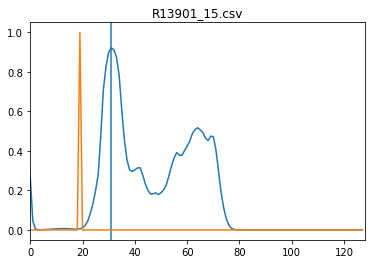

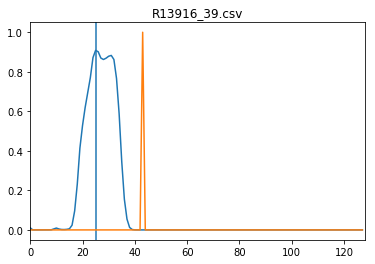

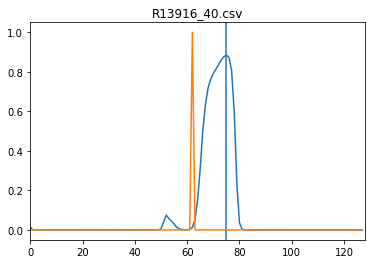

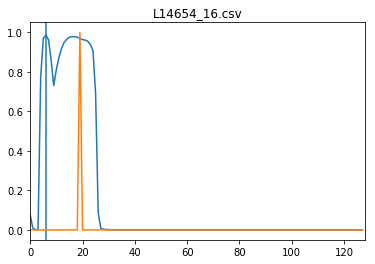

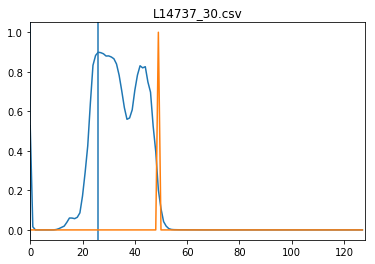

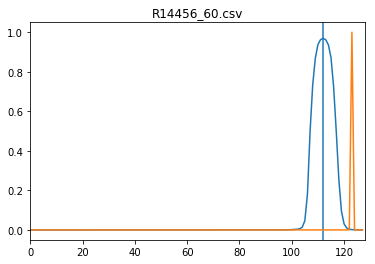

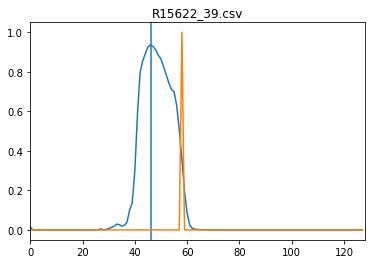

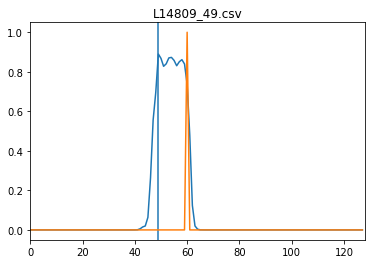

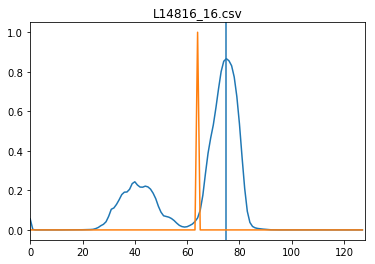

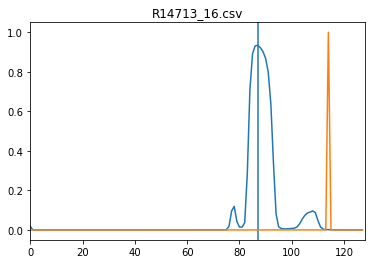

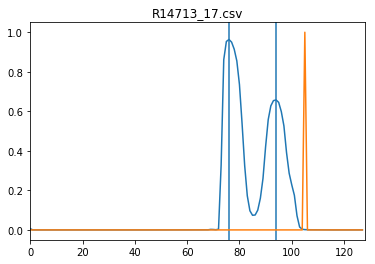

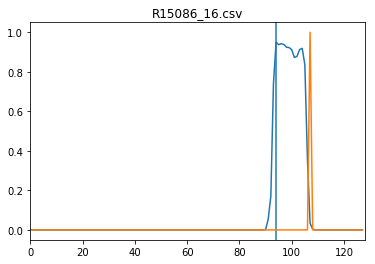

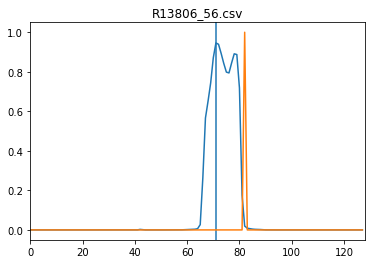

In [25]:
%matplotlib inline   
sdist = []
res = model.predict(inputs[ntrain:n,:,cols])

for ntrial in range(n - ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrain + ntrial,:,:]
    d = eval_prediction(likelihood, true, ids[ntrain + ntrial], plot = False, shift = 0)
    sdist.extend(d)
    if (d[0] > 10):
        eval_prediction(likelihood, true, ids[ntrain + ntrial], plot = True, shift = 0)

(Note that cases plotted above are only the 'problematic' ones, i.e. ~5% of all. Most of the predictions are excelent.)
We draw distribution of the 'real-world' error, i.e. the average distance between the real peak and the closest predicted peak. For now we analyze only $\verb|coverage|$ introduced before.

Error distribution:
<= 1: 0.797447
<= 3: 0.939512
<= 5: 0.972253
<= 10: 0.992786
<= 60: 1.000000
Mean distance: 1.138180


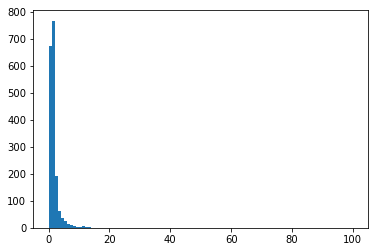

In [27]:
plot_stats(sdist)

Now, we try prediction on variable length sequences. Note, that we have only few annotations per trial, while there should be more, in periodic manner. It seems it's caputred by LSTM. Note that these long sequences were not used for training - these are situations that the network has never seen before and its not optimized for these cases directly.

In [ ]:
%matplotlib inline

sdist = []
files = os.listdir(fdir)
for i,filename in enumerate(files):
    R = np.loadtxt("%s/%s" % (fdir, filename), delimiter=',')
    X = R[:,cols]
    true = R[:,input_dim:(input_dim + output_dim)]
    likelihood = model.predict(X.reshape((1,-1,len(cols))))[0]

    sdist.extend(eval_prediction(likelihood, true, filename))
    
    if i > 20:
        break

## Problematic cases

Now we identify cases where algorithm didn't do well and we try to figure out what's wrong.

**'Big' problems**

In [ ]:
plot_kinematics("R11714_8.csv", fdir=fdir, ids=ids, fromfile=True, input_dim = input_dim, output_dim = output_dim, model = model, cols = cols)

**Off by 10-20 frames (not any more ;)**

In [ ]:
plot_kinematics("L9255_10.csv", fdir=fdir, ids=ids, fromfile=True, input_dim = input_dim, output_dim = output_dim, model = model, cols = cols)
plot_kinematics("R13353_14.csv", fdir=fdir, ids=ids, fromfile=True, input_dim = input_dim, output_dim = output_dim, model = model, cols = cols)
plot_kinematics("R12491_15.csv", fdir=fdir, ids=ids, fromfile=True, input_dim = input_dim, output_dim = output_dim, model = model, cols = cols)
plot_kinematics("L7920_19.csv", fdir=fdir, ids=ids, fromfile=True, input_dim = input_dim, output_dim = output_dim, model = model, cols = cols)
plot_kinematics("R9538_44.csv", fdir=fdir, ids=ids, fromfile=True, input_dim = input_dim, output_dim = output_dim, model = model, cols = cols)
plot_kinematics("L8641_11.csv", fdir=fdir, ids=ids, fromfile=True, input_dim = input_dim, output_dim = output_dim, model = model, cols = cols)

In [ ]:
print(model)
model.save("model-48-3-hee.h5")
pickle.dump( history.history, open( "history-48-3-hee.p", "wb" ) )